In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Flatten, Reshape, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from scipy.optimize import minimize
from sklearn.metrics import classification_report
from itertools import chain

# Load Real Data

In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [4]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(60).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(60).mean()

# Loading Model

In [13]:
model = load_model("LSTM_RESULTS_TRIMMED40_AVERAGED60/ACC67_VALACC67_RL2_C256_N10_E20_BS128_LR0.001/model/")

# Parameters Optimisation

In [14]:
indexes = ['1', '92', '110', '158', '286', '295', '375', '393', '460', '501', '606', '658', '675']
# indexes = ['375', '393']

In [15]:
def series_to_supervised(share_prices, timestamps, input_time_steps, dropnan=True):
    share_prices_df = pd.DataFrame(share_prices)
    timestamps_df = pd.DataFrame(timestamps)
    share_prices_timeseries = list()
    timestamps_timeseries = list()
    
    for i in range(input_time_steps-1, -1, -1):
        share_prices_timeseries.append(share_prices_df.shift(i))
        timestamps_timeseries.append(timestamps_df.shift(i))
    
    aggregated_share_prices = pd.concat(share_prices_timeseries, axis=1)
    aggregated_timestamps = pd.concat(timestamps_timeseries, axis=1)
    
    if dropnan:
        aggregated_share_prices.dropna(inplace=True)
        aggregated_timestamps.dropna(inplace=True)

    aggregated_timestamps = aggregated_timestamps.values
    aggregated_share_prices = aggregated_share_prices.values
    
    not_overlapping_indexes = range(0, 
                                    len(aggregated_share_prices), 
                                    input_time_steps)
    
    aggregated_timestamps = aggregated_timestamps[not_overlapping_indexes]
    aggregated_share_prices = aggregated_share_prices[not_overlapping_indexes]
    return aggregated_share_prices, aggregated_timestamps
 

def split(BP_data, HR_data, col, time_steps):
    X = []
    y = []

    BP_supervised, HR_supervised = series_to_supervised(BP_data[col], HR_data[col], time_steps)
    for BP_interval, HR_interval in zip(BP_supervised, HR_supervised):
        BP_HR_interval = []
        for BP_time_step, HR_time_step in zip(BP_interval, HR_interval):
            BP_HR_interval.append([BP_time_step, HR_time_step])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)

In [16]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [17]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 111, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 168, 'r')
index = '393' 
label_func('393', 31, 32, 'r')
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 140, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
label_func('110', 123, 125, 'r')
index = '158' 
label_func('158', 24, 28, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 61, 62, 'r')
label_func('286', 62, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')
index = '460' 
label_func('460', 49, 50, 'r')
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 59, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 35, 36, 'r')
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 80, 82, 'r')
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

In [19]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

In [37]:
classification_reports = dict()

def calc_accuracy_for_params(threshold):
    start = time.time()
    y_pred = np.array([])
    
    for i in indexes:
        X_val, _ = split(BP_data_scaled_averaged, HR_data_scaled_averaged, i, 32)
        pred_values = model.predict(X_val)
        pred_labels = ['r' if y[1] > threshold else 'g' for y in pred_values]
        y_pred = np.append(y_pred, pred_labels)
        
    y_true = np.array(list(chain(*BP_HR_validation_labels.values())), dtype=str)    
    class_report = classification_report(y_true, y_pred, output_dict=True)
    acc = class_report['accuracy']
    red_f1 = class_report['r']['f1-score']
    green_f1 = class_report['g']['f1-score']
    classification_reports[threshold] = class_report
    print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, threshold: {threshold:.3f}, time:{(time.time() - start):.2f}s")


In [38]:
thresholds = np.array(range(60, 81)) / 100
thresholds

array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ])

In [39]:
for t in thresholds:
    calc_accuracy_for_params(t)

Accuracy: 0.8440, Green F1: 0.9096, Red F1: 0.4314, threshold: 0.600, time:3.45s
Accuracy: 0.8480, Green F1: 0.9122, Red F1: 0.4350, threshold: 0.610, time:3.44s
Accuracy: 0.8554, Green F1: 0.9169, Red F1: 0.4444, threshold: 0.620, time:3.39s
Accuracy: 0.8574, Green F1: 0.9183, Red F1: 0.4421, threshold: 0.630, time:3.42s
Accuracy: 0.8635, Green F1: 0.9220, Red F1: 0.4528, threshold: 0.640, time:3.37s
Accuracy: 0.8695, Green F1: 0.9258, Red F1: 0.4611, threshold: 0.650, time:3.38s
Accuracy: 0.8776, Green F1: 0.9307, Red F1: 0.4740, threshold: 0.660, time:3.41s
Accuracy: 0.8837, Green F1: 0.9344, Red F1: 0.4836, threshold: 0.670, time:3.54s
Accuracy: 0.8863, Green F1: 0.9363, Red F1: 0.4768, threshold: 0.680, time:3.62s
Accuracy: 0.8884, Green F1: 0.9375, Red F1: 0.4747, threshold: 0.690, time:3.42s
Accuracy: 0.8904, Green F1: 0.9389, Red F1: 0.4691, threshold: 0.700, time:3.89s
Accuracy: 0.8877, Green F1: 0.9375, Red F1: 0.4452, threshold: 0.710, time:3.64s
Accuracy: 0.8897, Green F1: 

In [35]:
for i in thresholds:
    acc = classification_reports[i]['accuracy']
    red_f1 = classification_reports[i]['r']['f1-score']
    green_f1 = classification_reports[i]['g']['f1-score']
    print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, threshold: {i:.1f}")

Accuracy: 0.1399, Green F1: 0.0000, Red F1: 0.2454, threshold: 0.1
Accuracy: 0.2112, Green F1: 0.1579, Red F1: 0.2581, threshold: 0.2
Accuracy: 0.3362, Green F1: 0.3904, Red F1: 0.2716, threshold: 0.3
Accuracy: 0.6046, Green F1: 0.7237, Red F1: 0.3050, threshold: 0.4
Accuracy: 0.7740, Green F1: 0.8614, Red F1: 0.3891, threshold: 0.5
Accuracy: 0.8440, Green F1: 0.9096, Red F1: 0.4314, threshold: 0.6
Accuracy: 0.8904, Green F1: 0.9389, Red F1: 0.4691, threshold: 0.7
Accuracy: 0.8897, Green F1: 0.9396, Red F1: 0.3692, threshold: 0.8
Accuracy: 0.8716, Green F1: 0.9305, Red F1: 0.1511, threshold: 0.9


<IPython.core.display.Javascript object>


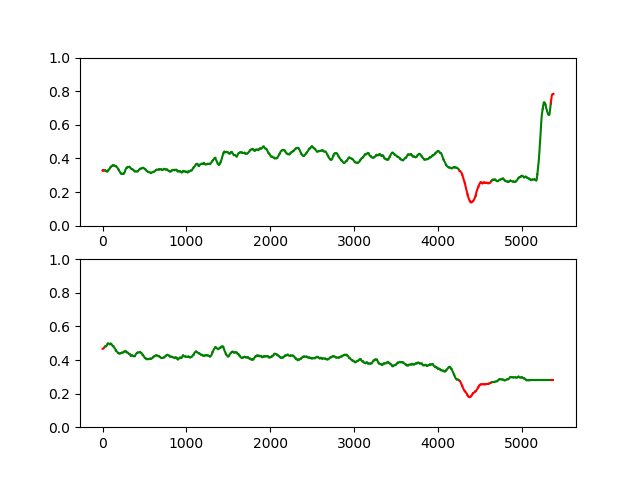

In [60]:
%matplotlib notebook
plt.ion()

n = '375'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)

t = 0
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        
        HR_BP_samples = []
        for HR_sample, BP_sample in zip(HRv, BPv):
            HR_BP_samples.append([HR_sample, BP_sample])
        pred_values = model.predict(np.expand_dims(HR_BP_samples, axis=0))
        c = ['r' if y[1] > 0.5 else 'g' for y in pred_values][0]

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')

        t += len(BPv)
    else:
        a = 5
        HR_BP_samples = []
        for HR_sample, BP_sample in zip(HRv, BPv):
            HR_BP_samples.append([HR_sample, BP_sample])
        pred_values = model.predict(np.expand_dims(HR_BP_samples, axis=0))
        c = ['r' if y[1] > 0.68 else 'g' for y in pred_values][0]

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 